In [1]:
import pandas as pd
from pandas.io.json import build_table_schema
from pandas.plotting import scatter_matrix
import seaborn as sns
import numpy as np
import scipy as sp
import os
import xgboost as xgb
import visualization as vis
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

DIR_PATH = './'

In [2]:
traindata  = pd.read_csv("./data/clean_train_only_complete_cols_chase.csv")
testdata = pd.read_csv("./data/clean_test_only_complete_cols_chase.csv")
print len(traindata.columns.values)
print 40 * '*'
print len(testdata.columns.values)
id_test = testdata.id


247
****************************************
246


In [4]:
traindata.loc[:, 'log_price_doc'] = np.log(traindata['price_doc'] + 1)

traindata.loc[:, 'year'] =  traindata.loc[:,'timestamp'].apply(lambda x: x[0:4])
traindata.loc[:, 'month'] =  traindata.loc[:, 'timestamp'].apply(lambda x: x[5:7])
testdata.loc[:, 'year'] = testdata.loc[:, 'timestamp'].apply(lambda x: x[0:4])
testdata.loc[:, 'month'] = testdata.loc[:, 'timestamp'].apply(lambda x: x[0:4])

In [5]:
from sklearn import model_selection, preprocessing
for f in testdata.columns:
    if testdata[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(testdata[f].values.astype('str')))
        testdata[f] = lbl.transform(list(testdata[f].values.astype('str')))

timestamp
product_type
sub_area
culture_objects_top_25
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
water_1line
big_road1_1line
railroad_1line
ecology
okurg_district
year
month


In [6]:
from sklearn import model_selection, preprocessing
for f in traindata.columns:
    if traindata[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(traindata[f].values.astype('str')))
        traindata[f] = lbl.transform(list(traindata[f].values.astype('str')))

timestamp
product_type
sub_area
culture_objects_top_25
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
water_1line
big_road1_1line
railroad_1line
ecology
okurg_district
year
month


In [7]:
feature_cols = ['full_sq', 'life_sq', 'floor', 'max_floor', 'kitch_sq',
               'kindergarten_km', 'school_km', 'park_km', 'green_zone_km', 'industrial_km',
               'metro_min_avto', 'railroad_km','public_transport_station_km','sub_area',
               'swim_pool_km','cemetery_km','public_healthcare_km','fitness_km','radiation_km',
               'big_road1_km', 'theater_km','market_shop_km','ID_metro','hospice_morgue_km',
               'metro_km_avto','ttk_km','church_synagogue_km','mosque_km','big_road2_km',
               'water_km','green_part_1500',
               'water_treatment_km','catering_km','university_km','big_church_km','shopping_centers_km',
               'detention_facility_km','additional_education_km','preschool_km','zd_vokzaly_avto_km',
               'power_transmission_line_km','area_m','workplaces_km']
# target_column  = ['log_price_doc']
target_column  = ['price_full']

In [8]:
X_data =  traindata[feature_cols]
y_data =  traindata[target_column]
X_testdata = testdata[feature_cols] # note this only for Kaggle and there is no y_testdata

In [9]:
X_train = X_data.values
Y_train = y_data.values
X_test = X_testdata.values

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(29096, 43)
(29096, 1)
(7662, 43)


In [29]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
   'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0
}


dtrain = xgb.DMatrix(X_train,Y_train)
dtest = xgb.DMatrix(X_test)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)

num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

[0]	train-rmse:139636	test-rmse:139643
[50]	train-rmse:36404.3	test-rmse:37806.5
[100]	train-rmse:32795.1	test-rmse:35529.7
[150]	train-rmse:31459.9	test-rmse:35223.5
[200]	train-rmse:30427.2	test-rmse:35077.1
[250]	train-rmse:29504.9	test-rmse:34998.6
[300]	train-rmse:28671.2	test-rmse:34940.5
[350]	train-rmse:27911.1	test-rmse:34885
[400]	train-rmse:27240.4	test-rmse:34864
[450]	train-rmse:26625.2	test-rmse:34856.5


(array([  2.07000000e+02,   1.81300000e+03,   2.63400000e+03,
          2.31800000e+03,   5.40000000e+02,   1.03000000e+02,
          2.90000000e+01,   1.40000000e+01,   2.00000000e+00,
          2.00000000e+00]),
 array([  48255.0546875 ,   82515.63359375,  116776.2125    ,
         151036.79140625,  185297.3703125 ,  219557.94921875,
         253818.528125  ,  288079.10703125,  322339.6859375 ,
         356600.26484375,  390860.84375   ]),
 <a list of 10 Patch objects>)

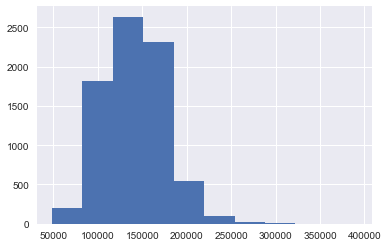

In [30]:
y_predict = model.predict(dtest)
plt.hist(y_predict)

In [31]:
#y_predict_new =  np.exp(y_predict) - 1
y_predict_new = y_predict * testdata.full_sq * 0.975
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict_new})

(array([  5.02600000e+03,   2.22900000e+03,   2.97000000e+02,
          6.90000000e+01,   1.90000000e+01,   9.00000000e+00,
          7.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          2.00000000e+00]),
 array([  1966806.41015625,   7678553.04422578,  13390299.67829531,
         19102046.31236484,  24813792.94643437,  30525539.5805039 ,
         36237286.21457343,  41949032.84864296,  47660779.48271249,
         53372526.11678202,  59084272.75085156]),
 <a list of 10 Patch objects>)

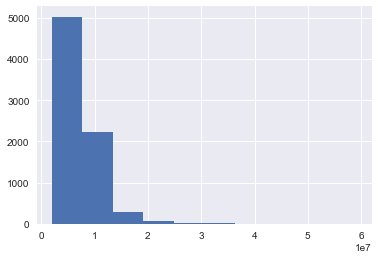

In [32]:
plt.hist(y_predict_new)

In [34]:
print output.shape
output.to_csv('submission_xgb_05_30_17_newcolumns_FUDGE97.5.csv', index=False)

(7662, 2)
